In [29]:
import tensorflow as tf 
import matplotlib.pyplot as plt 
import warnings

warnings.filterwarnings('ignore')

In [30]:
(train_images, train_labels), _ = tf.keras.datasets.fashion_mnist.load_data()

In [31]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5)/127.5

In [32]:
batch_size = 256
train_ds = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size)

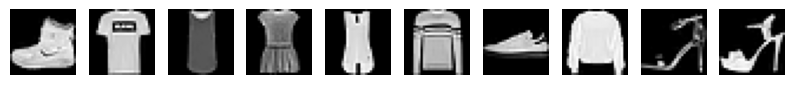

In [33]:
num_images_to_show = 10
plt.figure(figsize=(10,10))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i+1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

In [34]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [35]:
def constroi_gerador():
    modelo = Sequential()

    modelo.add(layers.Input(shape=(100, )))
    modelo.add(layers.Dense(7*7*256,use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Reshape((7, 7, 256)))
    modelo.add(layers.Conv2DTranspose(128, (5,5),strides=(1,1), padding='same', use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Conv2DTranspose(64, (5,5),strides=(2,2), padding='same', use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Conv2DTranspose(1, (5,5),strides=(2,2), padding='same', use_bias=False, activation='tanh'))

    return modelo

In [36]:
gerador = constroi_gerador()


In [37]:
dimensao_ruido = 100
ruido = tf.random.normal([1, dimensao_ruido])

In [38]:
imagem_gerada = gerador(ruido, training = False)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

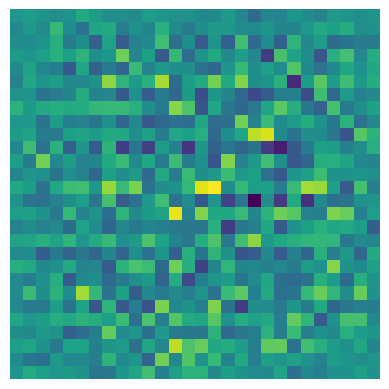

In [39]:
plt.imshow(imagem_gerada[0]*127.5+127.5)
plt.axis('off')

In [40]:
def constroi_discriminador():

    modelo = Sequential()
    modelo.add(layers.Input(shape=(28,28,1)))
    modelo.add(layers.Conv2D(64,(5,5), strides=(2,2), padding='same'))
    modelo.add(layers.LeakyReLU())
    modelo.add(layers.Dropout(0.3))

    modelo.add(layers.Conv2D(128,(5,5), strides=(2,2), padding='same'))
    modelo.add(layers.LeakyReLU())
    modelo.add(layers.Dropout(0.3))

    modelo.add(layers.Flatten())
    modelo.add(layers.Dense(1))

    return modelo

In [41]:
discriminador = constroi_discriminador()
decisao = discriminador(imagem_gerada)
print(decisao)

tf.Tensor([[0.00281749]], shape=(1, 1), dtype=float32)


In [42]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [43]:
def custo_discriminador(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [44]:
def custo_gerador(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [45]:
otimizador_gerador = tf.keras.optimizers.Adam(1e-4)
otimizador_discriminador = tf.keras.optimizers.Adam(1e-4)

In [46]:
import os

In [47]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=otimizador_gerador,
                                 discriminator_optimizer=otimizador_discriminador,
                                 generator=gerador,
                                 discriminator=discriminador
                                 )

In [48]:
epocas = 50
dimensao_ruido = 100
numero_exemplos_treinamento = 16

seed = tf.random.normal([numero_exemplos_treinamento, dimensao_ruido])

In [49]:
@tf.function
def passo_treino(images):
    ruido = tf.random.normal([batch_size, dimensao_ruido])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gerador(ruido, training=True)
        real_output = discriminador(images, training=True)
        fake_output = discriminador(generated_images, training=True)
        gen_loss = custo_gerador(fake_output)
        disc_loss = custo_discriminador(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gerador.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

    otimizador_gerador.apply_gradients(zip(gradients_of_generator, gerador.trainable_variables))
    otimizador_discriminador.apply_gradients(zip(gradients_of_discriminator, discriminador.trainable_variables))


In [50]:
import time
from IPython.display import clear_output

In [51]:
def treino(dataset, epocas):
    for epoca in range(epocas):
        start = time.time()

        for image_batch in dataset:
            passo_treino(image_batch)

        clear_output(wait=True)
        gera_e_salva_imagens(gerador,
                             epoca + 1,
                             seed)
        
        if(epoca + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Tempo por época {} é {} s'.format(epoca + 1, time.time()-start))

    clear_output(wait=True)
    gera_e_salva_imagens(gerador,
                                epoca + 1,
                                seed)

In [52]:
def gera_e_salva_imagens(modelo, epoca, entrada):
    previsao = modelo(entrada, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(previsao.shape[0]):
        plt.subplot(4,4, i+1)
        plt.imshow(previsao[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoca))
    plt.show()

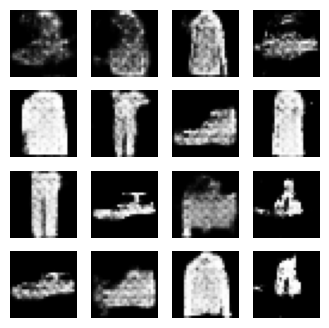

In [53]:
treino(train_ds,epocas)

In [54]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [55]:
gerador.save('modelo_gerador.keras')

In [56]:
from tensorflow.keras.models import load_model
gerador_carregado = load_model('modelo_gerador.keras')

In [57]:
new_noise = tf.random.normal([1, dimensao_ruido])

In [60]:
new_generated_image = gerador_carregado(new_noise,training=False)

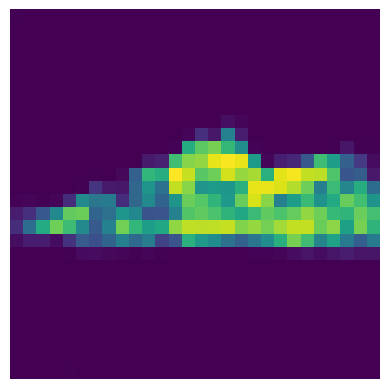

In [61]:
plt.imshow((new_generated_image[0] * 127.5 + 127.5).numpy())
plt.axis('off')
plt.show()